In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import torch
import time

In [2]:
from cocoa_emu import *
from cocoa_emu.emulator import NNEmulator, GPEmulator
from cocoa_emu.data_model import LSST_3x2

In [3]:
configfile = 'configs/nn_emu.yaml'

In [4]:
config = Config(configfile)

config_args     = config.config_args
config_args_io  = config_args['io']
config_args_data = config_args['data']

In [5]:
savedir = 'output/nn_emu/'

N_DIM         = 17
data_model    = LSST_3x2(N_DIM, config_args_io, config_args_data)
data_model.emu_type = 'nn'

In [6]:
OUTPUT_DIM = 1560

emu = NNEmulator(N_DIM, OUTPUT_DIM, data_model.dv_fid, data_model.dv_std)    
emu.load('model/nn_emu/model')
# ======================================================

data_model.emu = emu

## Accounting for galaxy bias, shear calibration bias and baryon PCAs

Linear galaxy bias, shear calibration bias and baryons impact the 3x2pt data vector in a simple way as additive and multiplicative factors. Therefore, these parameters are not part of the emulation and instead the effect of these parameters are a-posteriori.

- $\textbf{Galaxy bias}$: The linear galaxy bias impacts the galaxy auto-correlation and the galaxy-galaxy lensing as, 

$
\begin{align}
w^{i} &\rightarrow b^2_{(i)}w^{i} \\
\gamma_t^{i} &\rightarrow b_{(i)}\gamma_t \\
\end{align}
$

- $\textbf{Shear calibration bias}$: The shear calibration bias impacts the galaxy-galaxy lensing and the cosmic shear part of the 3x2 pt data vectors as, 

$
\begin{align}
\xi^{ij}_{\pm} &\rightarrow (1 + m^i) (1 + m^j) \xi^{ij}_{\pm}\\
\gamma^{ij}_{t} &\rightarrow (1 + m^j) \gamma^{ij}_{t}
\end{align}
$

- $\textbf{Baryons}$: The impact of the baryons are modeled using the PCA marginalization approach. The PCA modes are pre-calculated and then added after multiplying by the PCA amplitude.
$
\begin{align}
\xi_{\pm} \rightarrow \xi_{\pm} + \sum_{i=1}^{N_{\textrm{PCA}}} Q_i \textrm{PCA}_i
\end{align}
$

To model these effects, we precalculate the part of the 3x2pt data vector that is modified due to galaxy bias and the shear calibration bias and save those as data vector `masks`. Similarly the baryon PCA modes are pre-calculated and simply added to the full data vector.

To begin with, we do not model the baryonic effects. As we will see, this leads to biased results if we go to small scales. But the bias goes away when we marginalize the baryonic effects using this PCA approach

In [7]:
bias_fid         = data_model.bias_fid
bias_mask        = data_model.bias_mask
shear_calib_mask = data_model.shear_calib_mask

In [8]:
def add_bias(bias_theta, datavector):
    for i in range(5):
        factor = (bias_theta[i] / bias_fid[i])**bias_mask[i]
        datavector = factor * datavector
    return datavector

def add_shear_calib(m, datavector):
    for i in range(5):
        factor = (1 + m[i])**shear_calib_mask[i]
        datavector = factor * datavector
    return datavector

In [9]:
def get_data_vector_emu(theta):
    """
    Function to get the emulated data vector (including the effect of galaxy bias, baryons, etc.)
    """
    cosmo_ia_dz_theta = theta[:17]
    bias        = theta[17:22]
    shear_calib = theta[22:27]
    baryon_q    = theta[27:]
    datavector = data_model.compute_datavector(cosmo_ia_dz_theta)
    datavector = np.array(datavector)
    datavector = add_bias(bias, datavector)
    datavector = add_shear_calib(shear_calib, datavector)
    return datavector

In [14]:
def hard_prior(theta, params_prior):
    """
    A function to impose a flat prior on a set of parameters.
    :theta: The set of parameter values
    :params_prior: The minimum and the maximum value of the parameters on which this prior is imposed
    """
    is_lower_than_min = bool(np.sum(theta < params_prior[:,0]))
    is_higher_than_max = bool(np.sum(theta > params_prior[:,1]))
    if is_lower_than_min or is_higher_than_max:
        return -np.inf
    else:
        return 0.
    
cosmo_prior_lim = np.array([[1.61, 3.91],
                       [0.87, 1.07],
                       [55, 91],
                       [0.01, 0.04],
                       [0.001, 0.99]])

ia_prior_lim = np.array([[-5., 5.],
                       [-5., 5.]])

bias_prior_lim = np.array([[0.8, 3.],
                       [0.8, 3.],
                       [0.8, 3.],
                       [0.8, 3.],
                       [0.8, 3.]])

baryon_prior_lim = np.array([[-3., 12.],
                             [-2.5, 2.5]])

baryon_prior_lim = 3. * baryon_prior_lim 

dz_source_std   = 0.002 * np.ones(5)
dz_lens_std     = 0.005 * np.ones(5)
shear_calib_std = 0.005 * np.ones(5)
    
def lnprior(theta):
    cosmo_theta = theta[:5]
    ns          = cosmo_theta[1]

    ns_prior    = 0.
    
    dz_source   = theta[5:10]
    ia_theta    = theta[10:12]
    dz_lens     = theta[12:17]
    bias        = theta[17:22]
    shear_calib = theta[22:27]
    baryon_q    = theta[27:]
    
    cosmo_prior = hard_prior(cosmo_theta, cosmo_prior_lim) + ns_prior
    ia_prior    = hard_prior(ia_theta, ia_prior_lim)
    bias_prior  = hard_prior(bias, bias_prior_lim)
    baryon_prior = hard_prior(baryon_q, baryon_prior_lim)
    
    dz_source_lnprior   = -0.5 * np.sum((dz_source / dz_source_std)**2)
    dz_lens_lnprior     = -0.5 * np.sum((dz_lens / dz_lens_std)**2)
    shear_calib_lnprior = -0.5 * np.sum((shear_calib / shear_calib_std)**2)
    
    return cosmo_prior + ia_prior + dz_source_lnprior + dz_lens_lnprior + \
            shear_calib_lnprior + bias_prior + baryon_prior
    
def ln_lkl(theta):
    model_datavector = get_data_vector_emu(theta)[0]
    delta_dv = (model_datavector - data_model.dv_obs)[data_model.mask_3x2]
    return -0.5 * delta_dv @ data_model.masked_inv_cov @ delta_dv

def lnprob(theta):
    return lnprior(theta) + ln_lkl(theta)

### Sampling

We use `emcee` to sample the parameters using the emulator

In [18]:
import emcee

N_MCMC        = 500
N_WALKERS     = 120
NDIM_SAMPLING = 29

theta0    = np.array([3.0675, 0.97, 69.0, 0.0228528, 0.1199772, 
                      0., 0., 0., 0., 0.,
                      0.5, 0.,
                      0., 0., 0., 0., 0.,
                      1.24, 1.36, 1.47, 1.60, 1.76,
                      0., 0., 0., 0., 0.,
                      0., 0.])

theta_std = np.array([0.01, 0.001, 0.1, 0.001, 0.002, 
                      0.002, 0.002, 0.002, 0.002, 0.002, 
                      0.1, 0.1,
                      0.005, 0.005, 0.005, 0.005, 0.005, 
                      0.03, 0.03, 0.03, 0.03, 0.03,
                      0.005, 0.005, 0.005, 0.005, 0.005, 
                      0.1, 0.1]) 

# Starting position of the emcee chain
pos0 = theta0[np.newaxis] + 3. * theta_std[np.newaxis] * np.random.normal(size=(N_WALKERS, NDIM_SAMPLING))

In [19]:
import os

os.environ["OMP_NUM_THREADS"] = "1"

from multiprocessing import Pool

In [20]:
start_time = time.time()
with Pool() as pool:
    emu_sampler = emcee.EnsembleSampler(N_WALKERS, NDIM_SAMPLING, lnprob, pool=pool)
    emu_sampler.run_mcmc(pos0, N_MCMC, progress=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:28<00:00, 17.46it/s]


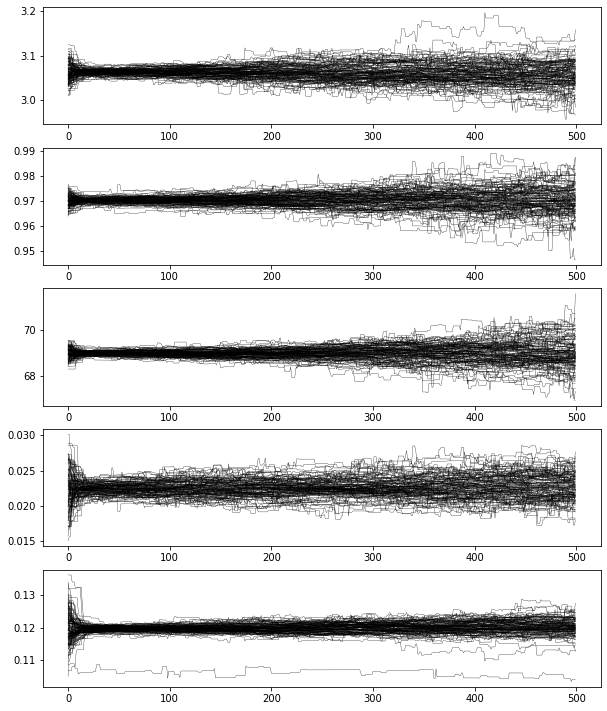

In [21]:
fig, ax = plt.subplots(5,1,figsize=(10,12.5))

for i in range(5):
    ax[i].plot(emu_sampler.chain[:,:,i].T, 'k-', lw=0.3)
    
plt.show()    

In [22]:
N_BURN_IN = 30
N_THIN    = 10

In [25]:
samples = emu_sampler.chain[:,N_BURN_IN::N_THIN].reshape((-1,NDIM_SAMPLING))
print(samples[:,:5].shape)

(5640, 5)


In [17]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [18]:
from getdist import plots, MCSamples
import getdist


def plot_cosmo_contours(sample_list, legend_labels):
    names = ['logA', 'ns', 'H0', 'omegab', 'omegac']
    labels =  ['logA', 'ns', 'H0', 'omega b', 'omega c']
    
    cosmo_truth = [3.0675, 0.97, 69., 0.0228528, 0.1199772]
    truth_dict = {}
    for name, truth in zip(names, cosmo_truth):
        truth_dict[name] = truth
        
    getdist_samples = []
    for samples, legend_label in zip(sample_list, legend_labels):
        cosmo_samples = samples[:,:5]
        getdist_samples.append(MCSamples(samples=cosmo_samples,names = names, labels=labels, label=legend_label))
    
    g = plots.get_subplot_plotter()
    g.triangle_plot(getdist_samples, filled=True, markers=truth_dict)
    
    plt.show()

Removed no burn in


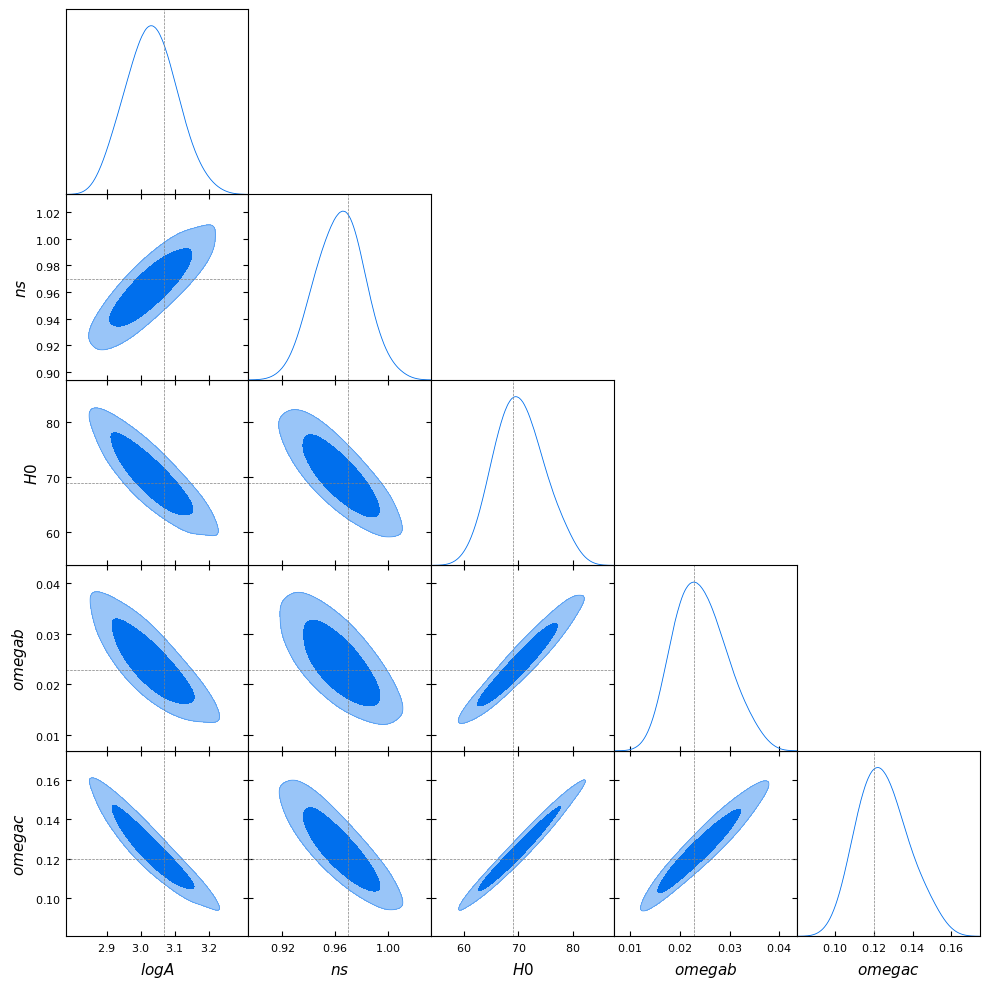

In [19]:
plot_cosmo_contours([samples], ['Fiducial scalecut'])

### Change scale cut

In [20]:
config_args_data_baryon_mask = config_args_data.copy()
config_args_data_baryon_mask['scalecut_mask'] = 'data/lsst_y1/lsst_3x2_baryon.mask'

In [21]:
data_model = LSST_3x2(N_DIM, config_args_io, config_args_data_baryon_mask)
data_model.emu_type = 'nn'
data_model.emu = emu

In [22]:
start_time = time.time()
with Pool() as pool:
    emu_sampler = emcee.EnsembleSampler(N_WALKERS, NDIM_SAMPLING, lnprob, pool=pool)
    emu_sampler.run_mcmc(pos0, N_MCMC, progress=True)

100%|██████████| 5000/5000 [02:45<00:00, 30.23it/s]


In [23]:
samples_baryon_scalecut = emu_sampler.chain[:,N_BURN_IN::N_THIN].reshape((-1,NDIM_SAMPLING))

Removed no burn in
Removed no burn in


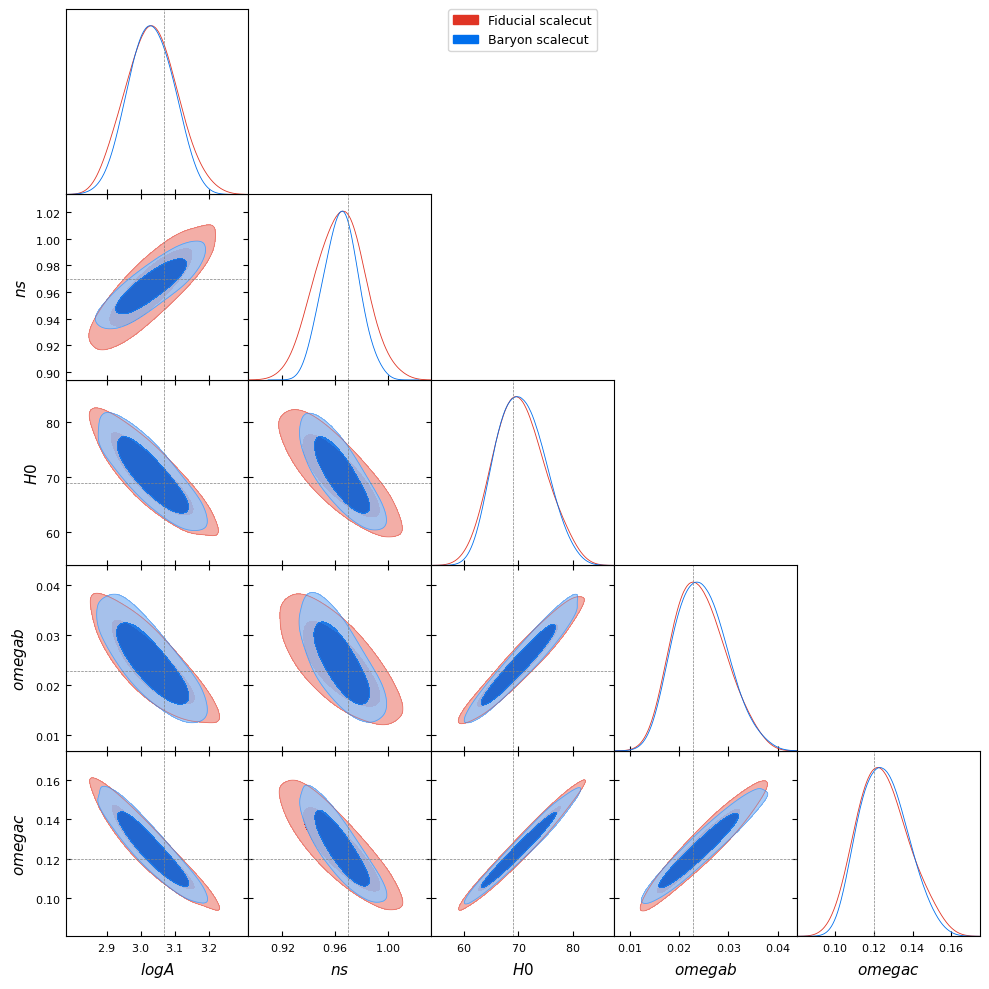

In [24]:
plot_cosmo_contours([samples, samples_baryon_scalecut], ['Fiducial scalecut', 'Baryon scalecut'])

### Baryon contaminated data vector

In [25]:
dv_bahamas = np.loadtxt('data/lsst_y1/lsst_y1_dv_BAHAMAS_T80')[:,1]
data_model.dv_obs = dv_bahamas

In [26]:
start_time = time.time()
with Pool() as pool:
    baryon_contaminated_sampler = emcee.EnsembleSampler(N_WALKERS, NDIM_SAMPLING, lnprob, pool=pool)
    baryon_contaminated_sampler.run_mcmc(pos0, N_MCMC, progress=True)

100%|██████████| 5000/5000 [02:46<00:00, 30.06it/s]


In [27]:
samples_baryon_contaminated = baryon_contaminated_sampler.chain[:,N_BURN_IN::N_THIN].reshape((-1,NDIM_SAMPLING))

Removed no burn in
Removed no burn in
Removed no burn in


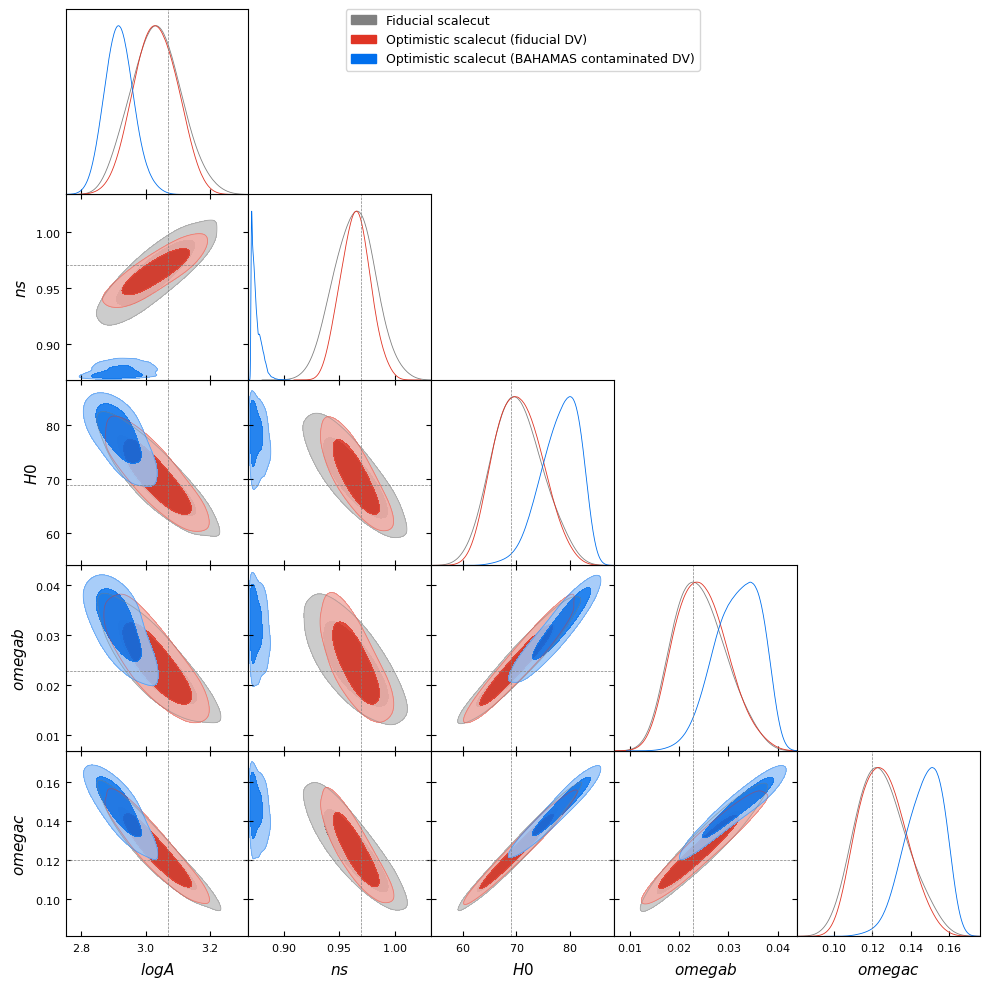

In [28]:
plot_cosmo_contours([samples, 
                     samples_baryon_scalecut, 
                     samples_baryon_contaminated], 
                    ['Fiducial scalecut', 
                     'Optimistic scalecut (fiducial DV)',
                     'Optimistic scalecut (BAHAMAS contaminated DV)'])

### Marginalizing Baryonic effects using the PCA approach

In [29]:
def add_baryon_q(Q, datavector):
    for i in range(2):
        datavector = datavector + Q[i] * data_model.baryon_pca[:,i]
    return datavector

def get_data_vector_emu(theta):
    """
    Function to get the emulated data vector (including the effect of galaxy bias, baryons, etc.)
    """
    cosmo_ia_dz_theta = theta[:17]
    bias        = theta[17:22]
    shear_calib = theta[22:27]
    baryon_q    = theta[27:]
    datavector = data_model.compute_datavector(cosmo_ia_dz_theta)
    datavector = np.array(datavector)
    datavector = add_bias(bias, datavector)
    datavector = add_shear_calib(shear_calib, datavector)
    # ================ ADD Baryonic effects ===================
    datavector = add_baryon_q(baryon_q, datavector)
    # =========================================================
    return datavector

In [30]:
start_time = time.time()
with Pool() as pool:
    baryon_contaminated_sampler_w_PCA = emcee.EnsembleSampler(N_WALKERS, NDIM_SAMPLING, lnprob, pool=pool)
    baryon_contaminated_sampler_w_PCA.run_mcmc(pos0, N_MCMC, progress=True)

100%|██████████| 5000/5000 [02:46<00:00, 29.96it/s]


In [31]:
samples_baryon_contaminated_w_PCA = baryon_contaminated_sampler_w_PCA.chain[:,N_BURN_IN::N_THIN].reshape((-1,NDIM_SAMPLING))

Removed no burn in
Removed no burn in
Removed no burn in


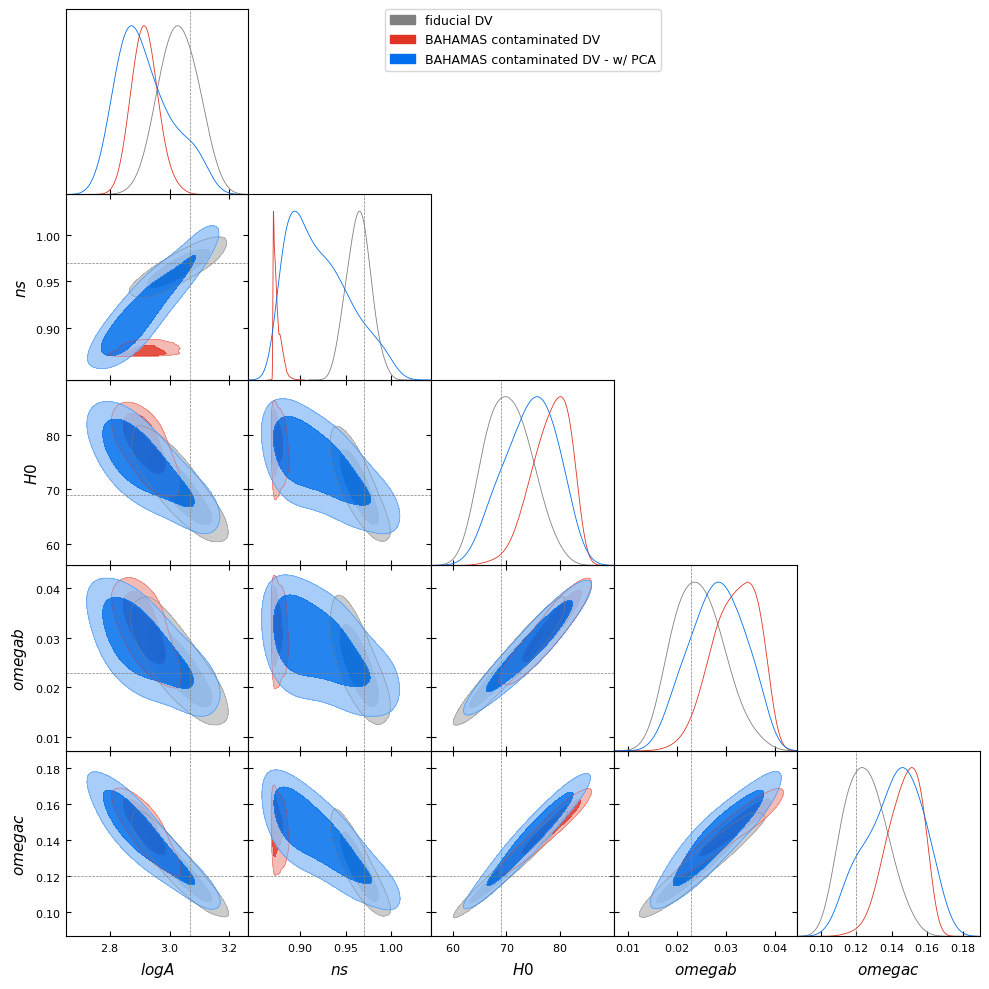

In [32]:
plot_cosmo_contours([samples_baryon_scalecut, 
                     samples_baryon_contaminated,
                     samples_baryon_contaminated_w_PCA], 
                    ['fiducial DV',
                     'BAHAMAS contaminated DV',
                     'BAHAMAS contaminated DV - w/ PCA'])

### Try a different sampler (`zeus`)

You can change the sampler to use the sampler of your choice very easily. E.g, here we compare the performance of the sampler `zeus` to that of `emcee`

In [33]:
import zeus

with Pool() as pool:
    zeus_sampler = zeus.EnsembleSampler(N_WALKERS, NDIM_SAMPLING, lnprob, pool=pool)
    zeus_sampler.run_mcmc(pos0, N_MCMC)

Initialising ensemble of 120 walkers...
Sampling progress : 100%|██████████| 5000/5000 [19:42<00:00,  4.23it/s]


In [ ]:
fig, ax = plt.subplots(5,1,figsize=(10,12.5))

for i in range(5):
    ax[i].plot(zeus_sampler.chain[:,:,i].T, 'k-', lw=0.3)
    
plt.show()    

In [ ]:
# try vectorizing lnprob: